In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopandas.tools import sjoin

from shapely.geometry import Point, Polygon
import contextily as ctx

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load the GeoJSON data into a GeoDataFrame
parks_gdf = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/rjaj-zgq7?method=export&format=GeoJSON")

# Inspect the first few rows of the GeoDataFrame
parks_gdf.head()


,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,retired,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,geometry
0,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,False,111,M-11,Plgd Within Park,25,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((-73.94378 40.80593, -73.94352 ..."
1,Marcus Garvey Park,,10027,0.16204716,5 Ave Nr Madison & 124 St,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,False,111,M-11,Plgd Within Park,25,M058-06,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((-73.94196 40.80523, -73.94195 ..."
2,Marcus Garvey Park,,10027,0.31619017,E 121st & Madison Ave,68,9,Marcus Garvey Memorial Park-Mt. Morris East,13,M058,False,111,M-11,Plgd Within Park,25,M058-01,Mt. Morris East,30,M,"MULTIPOLYGON (((-73.94298 40.80315, -73.94295 ..."
3,Thomas Jefferson Park,,10029,0.33302291,E 111 St & 1 Ave,68,8,Thomas Jefferson Park-Thomas Jefferson Park,13,M047,False,111,M-11,Plgd Within Park,23,M047-03,Thomas Jefferson Park,30,M,"MULTIPOLYGON (((-73.93583 40.79214, -73.93550 ..."
4,Wagner Houses Pool,,10035,1.11138215,E 124 St Bet 1 & 2 Aves,68,8,Wagner Pool-Othmar Ammann Playground,13,M273,False,111,M-11,Plgd Within Park,25,M273-01,Othmar Ammann Playground,30,M,"MULTIPOLYGON (((-73.93278 40.80150, -73.93262 ..."


In [2]:
parks_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# Ensure the GeoDataFrame is using a projected coordinate system for area calculation
# EPSG:2263 is for New York Long Island (feet)
parks_gdf = parks_gdf.to_crs(epsg=2263)  

# Calculate the area of each park in square feet
parks_gdf['area'] = parks_gdf.geometry.area
parks_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   propname         888 non-null    object  
 1   retireddate      888 non-null    object  
 2   zipcode          888 non-null    object  
 3   acres            888 non-null    object  
 4   location         888 non-null    object  
 5   nys_assembly     888 non-null    object  
 6   councildistrict  888 non-null    object  
 7   description      888 non-null    object  
 8   us_congress      888 non-null    object  
 9   gispropnum       888 non-null    object  
 10  retired          888 non-null    object  
 11  communityboard   888 non-null    object  
 12  department       888 non-null    object  
 13  subcategory      888 non-null    object  
 14  precinct         888 non-null    object  
 15  omppropid        888 non-null    object  
 16  sitename         888 non-null    obj

<Axes: >

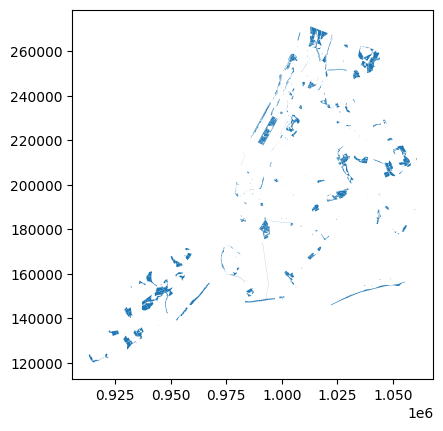

In [4]:
# Plot the parks
parks_gdf.plot()

In [5]:
# Check for missing values
print(parks_gdf.isnull().sum())

# Check the data types and attributes
print(parks_gdf.dtypes)

# Ensure all geometries are valid
parks_gdf = parks_gdf[parks_gdf.is_valid]

propname           0
retireddate        0
zipcode            0
acres              0
location           0
nys_assembly       0
councildistrict    0
description        0
us_congress        0
gispropnum         0
retired            0
communityboard     0
department         0
subcategory        0
precinct           0
omppropid          0
sitename           0
nys_senate         0
borough            0
geometry           0
area               0
dtype: int64
propname             object
retireddate          object
zipcode              object
acres                object
location             object
nys_assembly         object
councildistrict      object
description          object
us_congress          object
gispropnum           object
retired              object
communityboard       object
department           object
subcategory          object
precinct             object
omppropid            object
sitename             object
nys_senate           object
borough              object
geometry      

<Axes: >

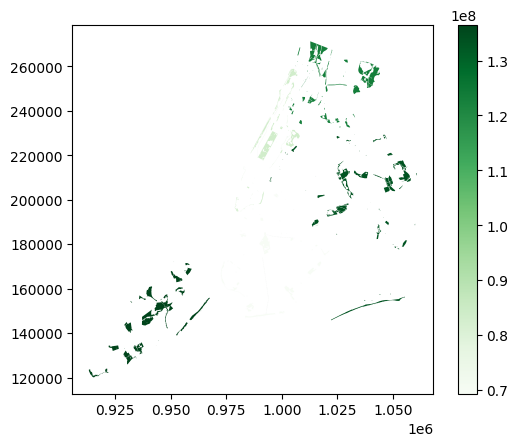

In [6]:
# Aggregate the data by borough and sum the park areas
park_areas_by_borough = parks_gdf.dissolve(by='borough', aggfunc='sum')
# Plot the results
park_areas_by_borough.plot(column='area', legend=True, cmap='Greens')

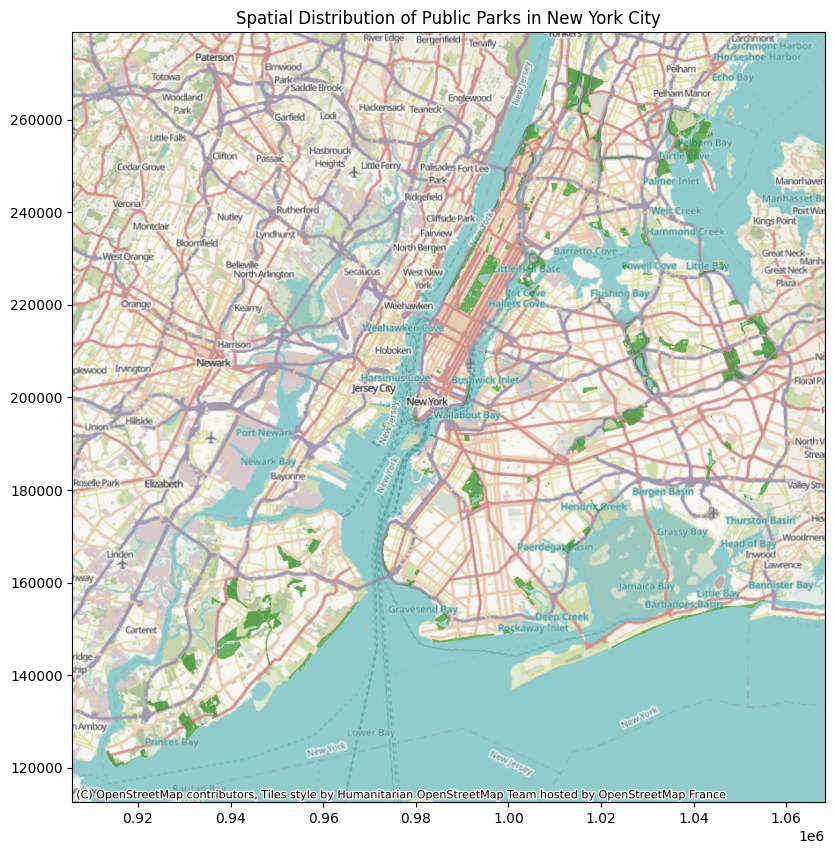

In [7]:
# Plot the parks
ax = parks_gdf.plot(figsize=(10, 10), color='green', alpha=0.5)
# Add a basemap
ctx.add_basemap(ax, crs=parks_gdf.crs.to_string())
# Set the title
ax.set_title("Spatial Distribution of Public Parks in New York City")
plt.show()

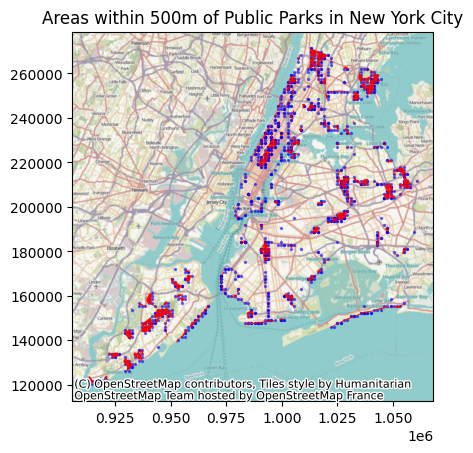

In [8]:
# Create a grid of points across the city
x = np.linspace(parks_gdf.bounds.minx.min(), parks_gdf.bounds.maxx.max(), num=100)
y = np.linspace(parks_gdf.bounds.miny.min(), parks_gdf.bounds.maxy.max(), num=100)
xx, yy = np.meshgrid(x, y)
grid_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xx.flatten(), yy.flatten()), crs=parks_gdf.crs)

# Create a buffer of 500 feet around each park (adjust the distance as needed)
parks_buffered = parks_gdf.buffer(500)

# Convert the buffered GeoSeries to a GeoDataFrame
parks_buffered_gdf = gpd.GeoDataFrame(geometry=parks_buffered)

# Perform the spatial join between grid points and buffered parks
points_near_parks = gpd.sjoin(grid_points, parks_buffered_gdf, how='inner', op='intersects')

# Visualize the result
ax = points_near_parks.plot(markersize=2, color='blue', alpha=0.5, label='Near Proximity to Parks')

parks_gdf.plot(ax=ax, color='red', alpha=1, label='Parks')

ctx.add_basemap(ax, crs=parks_gdf.crs.to_string())
ax.set_title("Areas within 500m of Public Parks in New York City")
plt.show()

<Axes: title={'center': 'Park Density per Borough (Parks per Square Mile)'}, xlabel='borough'>

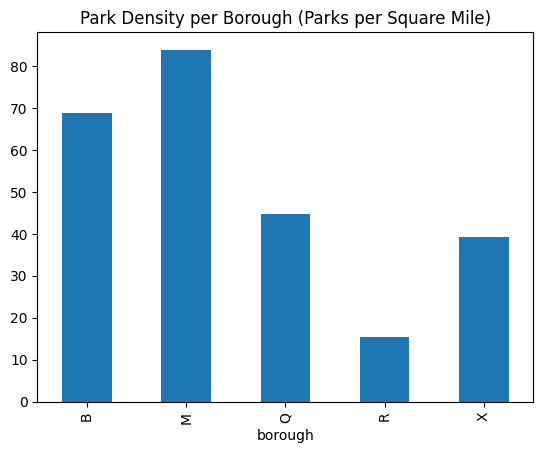

In [9]:
# Assuming the parks_gdf has a 'borough' column and is projected in EPSG:2263 for area calculation in feet
borough_area = parks_gdf.dissolve(by='borough', aggfunc='sum')['area']

# Count the number of parks in each borough
park_count = parks_gdf['borough'].value_counts()

# Calculate park density per square mile (since the area is in square feet, we convert it to square miles)
park_density = park_count / (borough_area / (5280**2))

# Plot park density
park_density.plot(kind='bar', title='Park Density per Borough (Parks per Square Mile)')


In [10]:
parks_gdf.columns

Index(['propname', 'retireddate', 'zipcode', 'acres', 'location',
       'nys_assembly', 'councildistrict', 'description', 'us_congress',
       'gispropnum', 'retired', 'communityboard', 'department', 'subcategory',
       'precinct', 'omppropid', 'sitename', 'nys_senate', 'borough',
       'geometry', 'area'],
      dtype='object')

In [11]:
# Largest park
largest_park = parks_gdf.iloc[parks_gdf['area'].idxmax()]
# Smallest park
smallest_park = parks_gdf.iloc[parks_gdf['area'].idxmin()]
print(f"Largest Park: {largest_park['propname']} in {largest_park['description']}, Area: {largest_park['area']} square feet")
print(f"Smallest Park: {smallest_park['propname']} in {smallest_park['description']}, Area: {smallest_park['area']} square feet")

Largest Park: Richmond Parkway in S.I. Greenbelt-Willowbrook Park Natural Area, Area: 6492278.962697325 square feet
Smallest Park: Blue Heron Park in Blue Heron Park - Blue Heron Tot Lot1, Area: 1453.3752954572674 square feet


In [12]:
# Define points of interest with their latitude and longitude coordinates
points_of_interest = {
    'Times Square': (-73.9855, 40.7580),
    'Central Park': (-73.9654, 40.7829),
    'Brooklyn Bridge': (-73.9969, 40.7061)
}
# Convert points of interest to a GeoDataFrame
poi_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in points_of_interest.values()], crs="EPSG:4326")
poi_gdf = poi_gdf.to_crs(parks_gdf.crs)  # Convert to the same CRS as parks_gdf for accurate distance calculation

poi_gdf


,geometry
0,POINT (988267.074 215436.879)
1,POINT (993831.986 224510.338)
2,POINT (985109.492 196527.766)


In [13]:
# Assuming parks_gdf is your GeoDataFrame containing parks
if parks_gdf.sindex is not None:  # Check if spatial index exists
    for index, poi in poi_gdf.iterrows():
        # Query the spatial index for the nearest geometry to each point of interest
        # Pass the point geometry directly instead of its bounds
        nearest_index = list(parks_gdf.sindex.nearest(poi.geometry, return_all=True, max_distance=None))[0]
        nearest_park = parks_gdf.iloc[nearest_index[0]]  # Access the first nearest park if there are multiple

        # Calculate the distance to the nearest park (in the same units as the CRS)
        distance = poi.geometry.distance(nearest_park.geometry)
        print(f"Nearest park to {index}: {nearest_park.geometry}, Distance: {distance:.2f}")


Nearest park to 0: MULTIPOLYGON (((999815.0771255483 232904.68154991002, 999886.0490964619 232864.82565849175, 999886.9788846368 232864.77972682333, 999887.8906282185 232864.59173506344, 999888.762673717 232864.2659483261, 999889.574679972 232863.80991249095, 999890.3066338892 232863.23511049149, 999890.9418032123 232862.5543375859, 999891.4650961305 232861.7843259978, 999940.9807451366 232833.9776230872, 999963.2759761349 232875.22557206775, 999836.8871212993 232944.72083991388, 999815.0771255483 232904.68154991002))), Distance: 20939.93
Nearest park to 1: MULTIPOLYGON (((999815.0771255483 232904.68154991002, 999886.0490964619 232864.82565849175, 999886.9788846368 232864.77972682333, 999887.8906282185 232864.59173506344, 999888.762673717 232864.2659483261, 999889.574679972 232863.80991249095, 999890.3066338892 232863.23511049149, 999890.9418032123 232862.5543375859, 999891.4650961305 232861.7843259978, 999940.9807451366 232833.9776230872, 999963.2759761349 232875.22557206775, 999836.8

In [14]:
parks_gdf.head()

,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,...,communityboard,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,geometry,area
0,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,111,M-11,Plgd Within Park,25,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226
1,Marcus Garvey Park,,10027,0.16204716,5 Ave Nr Madison & 124 St,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,111,M-11,Plgd Within Park,25,M058-06,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((1000318.465 232648.929, 100032...",7058.805985
2,Marcus Garvey Park,,10027,0.31619017,E 121st & Madison Ave,68,9,Marcus Garvey Memorial Park-Mt. Morris East,13,M058,...,111,M-11,Plgd Within Park,25,M058-01,Mt. Morris East,30,M,"MULTIPOLYGON (((1000036.662 231890.505, 100004...",20574.915580
3,Thomas Jefferson Park,,10029,0.33302291,E 111 St & 1 Ave,68,8,Thomas Jefferson Park-Thomas Jefferson Park,13,M047,...,111,M-11,Plgd Within Park,23,M047-03,Thomas Jefferson Park,30,M,"MULTIPOLYGON (((1002017.564 227881.773, 100210...",15448.096588
4,Wagner Houses Pool,,10035,1.11138215,E 124 St Bet 1 & 2 Aves,68,8,Wagner Pool-Othmar Ammann Playground,13,M273,...,111,M-11,Plgd Within Park,25,M273-01,Othmar Ammann Playground,30,M,"MULTIPOLYGON (((1002860.608 231290.719, 100290...",49288.794214


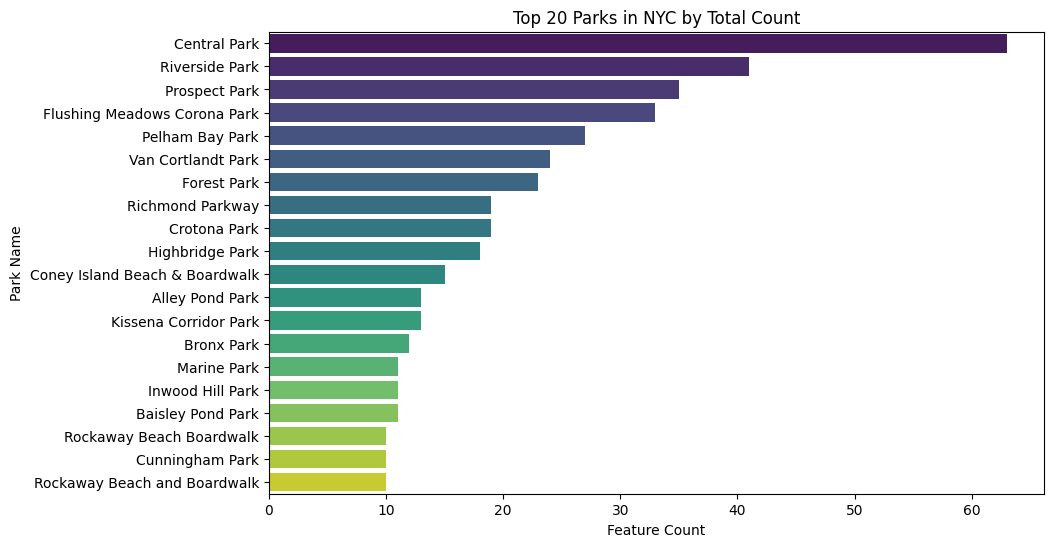

In [15]:
# Assuming 'propname' column contains unique identifiers for parks
feature_counts = parks_gdf['propname'].value_counts()

# Select the top 10 most common property names (parks)
top_10_parks = feature_counts.head(20).reset_index()
top_10_parks.columns = ['Park Name', 'Count']

# Create a Seaborn bar plot for the top 10 parks
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Park Name', data=top_10_parks, palette='viridis')

# Add plot title and labels
plt.title('Top 20 Parks in NYC by Total Count')
plt.xlabel('Feature Count')
plt.ylabel('Park Name')

plt.show()


In [16]:
parks_gdf['park_ids'] = parks_gdf.index + 1
parks_gdf

,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,...,department,subcategory,precinct,omppropid,sitename,nys_senate,borough,geometry,area,park_ids
0,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M-11,Plgd Within Park,25,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6.669386e+03,1
1,Marcus Garvey Park,,10027,0.16204716,5 Ave Nr Madison & 124 St,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M-11,Plgd Within Park,25,M058-06,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((1000318.465 232648.929, 100032...",7.058806e+03,2
2,Marcus Garvey Park,,10027,0.31619017,E 121st & Madison Ave,68,9,Marcus Garvey Memorial Park-Mt. Morris East,13,M058,...,M-11,Plgd Within Park,25,M058-01,Mt. Morris East,30,M,"MULTIPOLYGON (((1000036.662 231890.505, 100004...",2.057492e+04,3
3,Thomas Jefferson Park,,10029,0.33302291,E 111 St & 1 Ave,68,8,Thomas Jefferson Park-Thomas Jefferson Park,13,M047,...,M-11,Plgd Within Park,23,M047-03,Thomas Jefferson Park,30,M,"MULTIPOLYGON (((1002017.564 227881.773, 100210...",1.544810e+04,4
4,Wagner Houses Pool,,10035,1.11138215,E 124 St Bet 1 & 2 Aves,68,8,Wagner Pool-Othmar Ammann Playground,13,M273,...,M-11,Plgd Within Park,25,M273-01,Othmar Ammann Playground,30,M,"MULTIPOLYGON (((1002860.608 231290.719, 100290...",4.928879e+04,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,Richmond Parkway,,"10314, 10306",213.34027746,"Richmond Ave, Forest Hill Rd, Richmond Hill Rd...",63,51,S.I. Greenbelt-Field of Dreams,11,R065,...,R-02,Large Park Zone,122,R065-ZN12,Field of Dreams,24,R,"MULTIPOLYGON (((938885.489 146886.291, 938739....",2.588176e+06,884
884,Richmond Parkway,,"10314, 10306",213.34027746,"Richmond Ave, Forest Hill Rd, Richmond Hill Rd...",63,51,S.I. Greenbelt-Southwest LaTourette,11,R065,...,R-02,Large Park Zone,122,R065-ZN13,Southwest LaTourette,24,R,"MULTIPOLYGON (((941358.132 149780.263, 941360....",2.708860e+06,885
885,Richmond Parkway,,10314,96.9048853,Rockland Ave & Forest Hill Rd - North Of Buck'...,63,50,S.I. Greenbelt-Northwest Latourette,11,R065,...,R-02,Large Park Zone,122,R065-ZN07,Northwest Latourette,24,R,"MULTIPOLYGON (((944765.339 151924.320, 944920....",4.537647e+06,886
886,Richmond Parkway,,10314,96.9048853,Rockland Ave & Forest Hill Rd - North Of Buck'...,63,50,S.I. Greenbelt-Southeast LaTourette,11,R065,...,R-02,Large Park Zone,122,R065-ZN16,Southeast LaTourette,24,R,"MULTIPOLYGON (((943266.030 148878.656, 943270....",2.339951e+06,887


In [17]:
# Assuming parks_gdf has a unique identifier for each park, like 'park_id'
park_ids = parks_gdf.index + 1
parks_gdf['park_id'] = parks_gdf.index + 1

# Generate sample dates
dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')

# Create a DataFrame to hold the visitation data
visitation_data = []

for park_id in parks_gdf['park_id']:
    for date in dates:
        # Generate a random number of visitors (between 0 and 500) for each park and date
        visitors = np.random.randint(0, 500)
        visitation_data.append({'park_id': park_id, 'date': date, 'visitors': visitors})

# Convert the list to a DataFrame
vis_df = pd.DataFrame(visitation_data)

# Ensure we have at least 1000 rows
assert len(vis_df) >= 1000

# Show the first few rows of the visitation DataFrame
vis_df.head()


,park_id,date,visitors
0,1,2021-01-01,83
1,1,2021-01-02,101
2,1,2021-01-03,460
3,1,2021-01-04,209
4,1,2021-01-05,471


<Axes: title={'center': 'Overall Park Visitation Trends in 2021'}, xlabel='Date', ylabel='Total Visitors'>

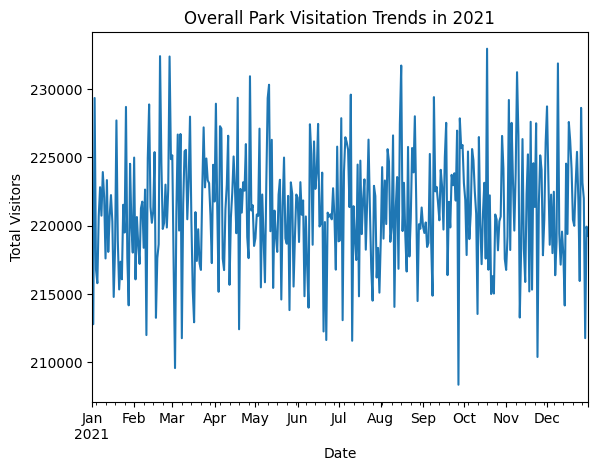

In [18]:
# Aggregate visitors by date to see overall trends
overall_trends = vis_df.groupby('date')['visitors'].sum()

# Plot overall visitation trends
overall_trends.plot(title='Overall Park Visitation Trends in 2021', ylabel='Total Visitors', xlabel='Date')

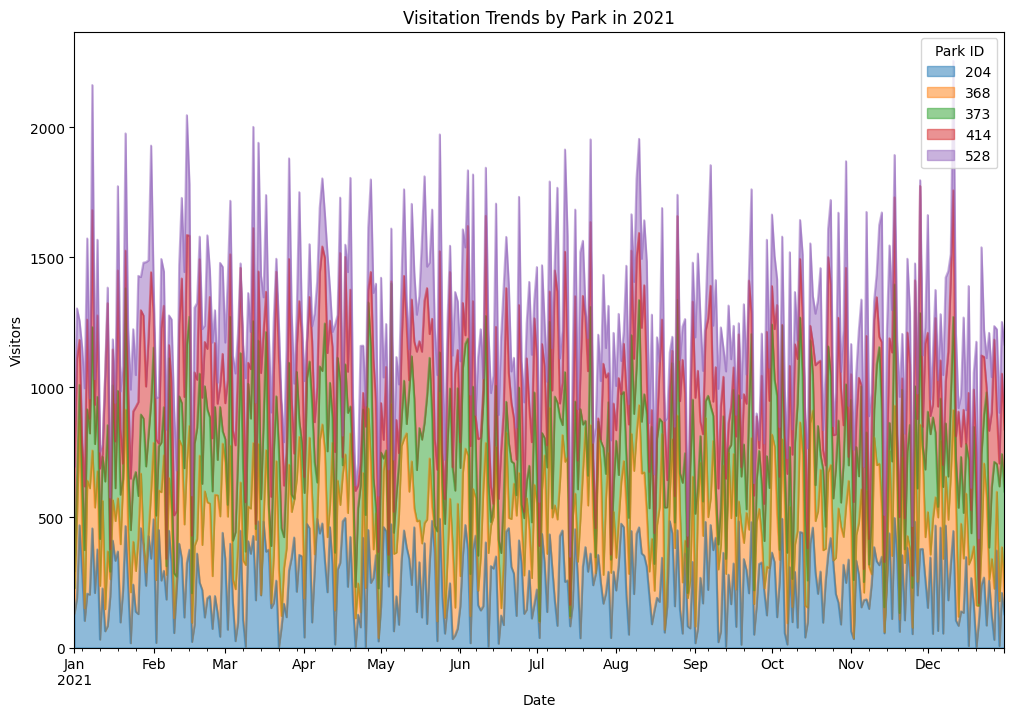

In [19]:
# Select a subset of parks for comparison
sample_parks = np.random.choice(park_ids, size=5, replace=False)
# Filter visitation data for the selected parks
sample_vis_df = vis_df[vis_df['park_id'].isin(sample_parks)]
# Pivot the data for plotting
pivot_df = sample_vis_df.pivot(index='date', columns='park_id', values='visitors')
# Plot visitation trends by park using an area plot
pivot_df.plot(kind='area', figsize=(12, 8), stacked=True, title='Visitation Trends by Park in 2021', alpha=0.5)

# Customizing the plot
plt.ylabel('Visitors')
plt.xlabel('Date')
plt.legend(title='Park ID', loc='upper right')
plt.show()


In [20]:
# Find the top 10 days with the highest visitation
peak_days = overall_trends.nlargest(10)
# Print the peak visitation days
print("Peak Visitation Days:")
print(peak_days)

Peak Visitation Days:
date
2021-10-18    232984
2021-02-20    232438
2021-02-27    232412
2021-12-09    231904
2021-08-16    231749
2021-11-09    231260
2021-04-27    230962
2021-05-11    230339
2021-07-10    229613
2021-09-09    229431
Name: visitors, dtype: int64


In [21]:
# Merge the parks GeoDataFrame with the visitation DataFrame on 'park_id'
combined_gdf = parks_gdf.merge(vis_df, on='park_id')

# Inspect the combined GeoDataFrame
combined_gdf.head()


,propname,retireddate,zipcode,acres,location,nys_assembly,councildistrict,description,us_congress,gispropnum,...,omppropid,sitename,nys_senate,borough,geometry,area,park_ids,park_id,date,visitors
0,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226,1,1,2021-01-01,83
1,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226,1,1,2021-01-02,101
2,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226,1,1,2021-01-03,460
3,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226,1,1,2021-01-04,209
4,Marcus Garvey Park,,10027,0.15435469,124 St Btwn 5 Ave And Mt Morris Park West,68,9,Marcus Garvey Memorial Park-Marcus Garvey Memo...,13,M058,...,M058-07,Marcus Garvey Memorial Park,30,M,"MULTIPOLYGON (((999815.077 232904.682, 999886....",6669.386226,1,1,2021-01-05,471


In [22]:
# Aggregate visitation data to get the total visitors per park
total_visitors_per_park = combined_gdf.groupby('park_id')['visitors'].sum().reset_index()

# Merge this aggregated data back with parks_gdf to maintain the spatial data
parks_with_visitors_gdf = parks_gdf.merge(total_visitors_per_park, on='park_id')


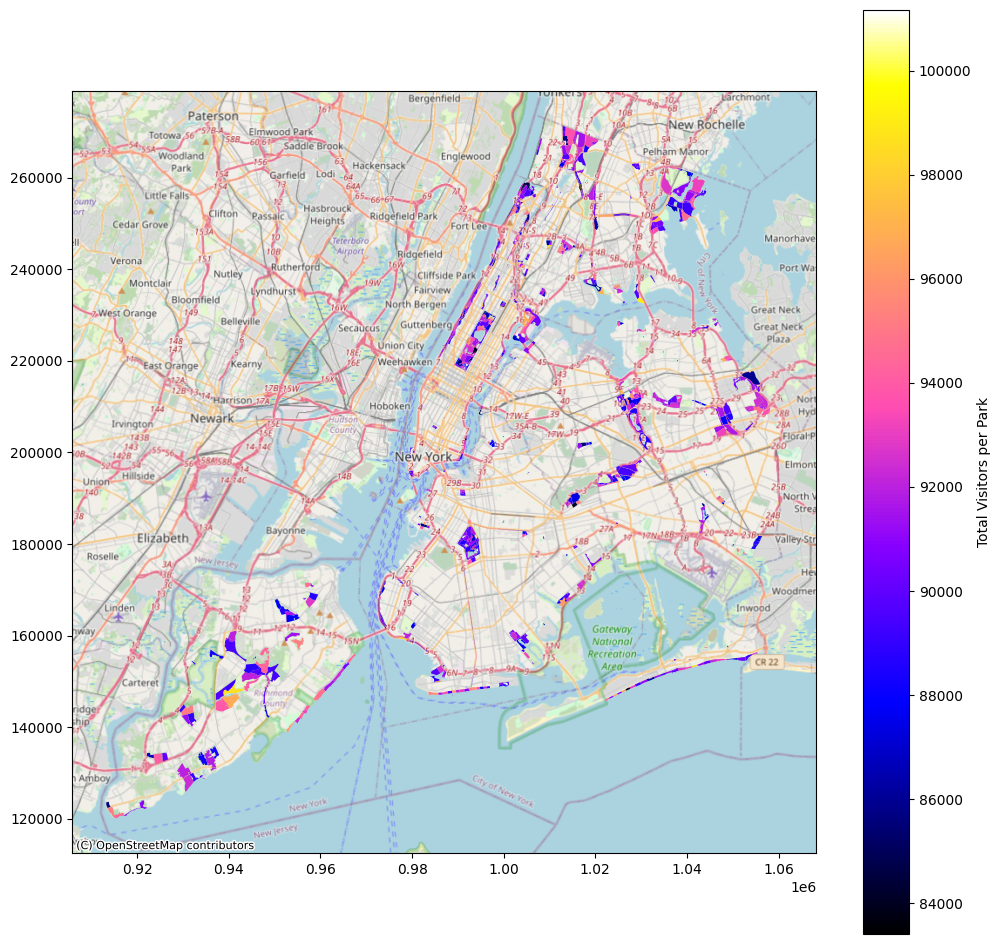

In [23]:
# Set up the figure and axis
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot parks, scaling the size of each park's point by the total visitors
# check this link to find cmap color: https://matplotlib.org/stable/users/explain/colors/colormaps.html
parks_with_visitors_gdf.plot(ax=ax, column='visitors', legend=True, legend_kwds={'label': "Total Visitors per Park"},
                             markersize=parks_with_visitors_gdf['visitors'] / 100,  # Scale marker size
                             cmap='gnuplot2')  # Use a color map

# Add basemap for reference (optional, requires contextily and Internet access)
try:
    import contextily as ctx
    ctx.add_basemap(ax, crs=parks_with_visitors_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap due to: {e}")

# Show the plot
plt.show()


In [24]:
# import geopandas as gpd
# import contextily as ctx
# import matplotlib.pyplot as plt

# # Assuming parks_with_visitors_gdf is already prepared and in the right CRS

# # Set up the figure and axis
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# # Plot parks, scaling the size of each park's point by the total visitors
# # Here we're using a fixed size for demonstration, but you might want to scale it based on 'visitors'
# parks_with_visitors_gdf.plot(ax=ax, column='visitors', legend=True,
#                              legend_kwds={'label': "Total Visitors per Park"},
#                              markersize=parks_with_visitors_gdf['visitors'] / 100,  # Scale marker size
#                              color='hotpink')  # Using a bright, distinct color

# # Add basemap for reference
# ctx.add_basemap(ax, crs=parks_with_visitors_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# # Remove axis clutter
# ax.set_axis_off()

# # Show the plot
# plt.show()


In [25]:
# # Set up the figure and axis
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# # Plot parks, scaling the size of each park's point by the total visitors
# parks_with_visitors_gdf.plot(ax=ax, column='visitors', legend=True, legend_kwds={'label': "Total Visitors per Park"},
#                              markersize=parks_with_visitors_gdf['visitors'] / 100,  # Scale marker size
#                              cmap='OrRd')  # Use a color map
# # Add basemap for reference (optional, requires contextily and Internet access)
# try:
#     import contextily as ctx
#     ctx.add_basemap(ax, crs=parks_with_visitors_gdf.crs.to_string(), source=ctx.providers.Stamen.OpenTopoMap)
# except Exception as e:
#     print(f"Couldn't add basemap due to: {e}")
# # Show the plot
# plt.show()